In [105]:
import torch
import torch.nn as nn
from math import pi
import random
import matplotlib.pyplot as plt
import IPython.display as ipd

#1. Make audio dataset

In [106]:
"""
Generate audio
"""
SR = 16000
def make_sine_wave(freq, amp, dur, sr):
  num_samples = dur * sr
  time_frame = torch.arange(num_samples)
  time_frame_sec = time_frame / sr
  return amp * torch.sin(2 * pi * freq * time_frame_sec)

def make_sine_wave_with_random_harmonics(freq, amp, dur, sr, num_harm=7):
  fund = make_sine_wave(freq,amp,dur,sr)
  for i in range(2, num_harm):
    fund += make_sine_wave(freq * i, amp*random.random()/i**(1+random.random()), dur, sr)
  return fund

def make_white_noise(amp, dur, sr):
  return torch.randn(dur*sr)*amp

def make_pitch_class_dataset(n_samples_per_pitch):
  pitches = [440., 466.2, 493.8, 523.3, 554.4, 587.3,
            622.3, 659.3, 698.5, 740., 784.0, 830.6]
  pitch_name = ['A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb' ,'E', 'F', 'Gb', 'G', 'Ab']
  dataset = [make_sine_wave_with_random_harmonics(pitch, 0.3 + random.random()/2, 3, SR, num_harm=3) + make_white_noise(random.random()*0.1, 3, SR) for pitch in pitches for i in range(n_samples_per_pitch)]
  pitches = [i for i in range(len(pitch_name)) for j in range(n_samples_per_pitch)]
  dataset = torch.stack(dataset)
  pitches = torch.LongTensor(pitches)
  return dataset, pitches


def make_random_pitch_dataset(n_samples, pitch_range=(220,880)):
  min_pitch, max_pitch = pitch_range
  pitches = [random.randint(min_pitch,max_pitch) for i in range(n_samples)]
  dataset = [make_sine_wave_with_random_harmonics(pitch,0.3,3,SR)+make_white_noise(random.random()*0.2, 3, SR) for pitch in pitches]
  dataset = torch.stack(dataset)
  pitches = torch.Tensor(pitches)
  return dataset, pitches

dataset, pitches = make_pitch_class_dataset(100)

In [107]:
dataset.shape

torch.Size([1200, 48000])

## 1.1 Monitor datasets

In [108]:
data_idx = random.randint(0, len(dataset)-1) #start, end  
data_sample = dataset[data_idx, :] 
ipd.display(ipd.Audio(data_sample, rate=SR))
print(f'Note pitch is {pitches[data_idx]}')

Note pitch is 11


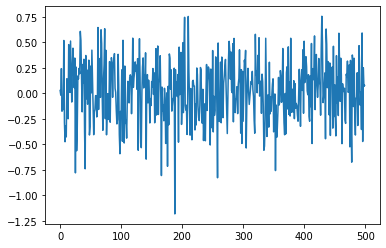

In [109]:
# plot white noise
noise = make_white_noise(amp=0.3, dur=3, sr=SR)
plt.plot(noise[:500])

## 1.2 Make Spectrograms

- 오디오 샘플을 처리하는 방법을 신경망이 학습하기 위해서는 데이터가 너무 많이 필요함
- 오디오 데이터는 STFT를 통해 Spectrogram으로 변환하는 것이 일반적

- Spectrogram

- MelSpectrogram

In [110]:
spec_converter_a = torchaudio.transforms.MelSpectrogram(sample_rate=SR, n_fft=512, f_min=200, f_max=3200, n_mels=48)
spec_converter_b = torchaudio.transforms.MelSpectrogram(sample_rate=SR, n_fft=4192, f_min=200, f_max=3200, n_mels=96)

spec_a = spec_converter_a(dataset)
spec_b = spec_converter_b(dataset)

In [111]:
amp_to_db_converter = torchaudio.transforms.AmplitudeToDB()
spec_a = amp_to_db_converter(spec_a)
spec_b = amp_to_db_converter(spec_b)

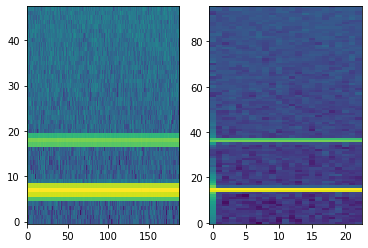

In [112]:
plt.subplot(1,2,1)
plt.imshow(spec_a[0], origin='below', aspect='auto', interpolation='nearest')
plt.subplot(1,2,2)
plt.imshow(spec_b[0], origin='below', aspect='auto', interpolation='nearest')

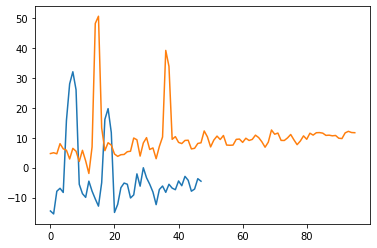

In [113]:
# spec_a의 차원축: 데이터샘플 x 주파수 축 x 시간 축
plt.plot(spec_a[0, :, 50])
plt.plot(spec_b[0, :, 5])

## 1.3 Split Dataset

In [114]:
rand_ids = torch.randperm(dataset.shape[0]) #1200
rand_ids[:10]

tensor([1120,  617, 1004,  694,  121,  101,  712,  487, 1154,  889])

In [115]:
spec_a = spec_a[rand_ids]
pitches = pitches[rand_ids]

In [116]:
train_ratio = 0.8
slice_idx = int(len(dataset) * 0.8)
train_set = spec_a[:slice_idx]
test_set = spec_a[slice_idx:]
train_label = pitches[:slice_idx]
test_label = pitches[slice_idx:]

In [117]:
test_set.shape

torch.Size([240, 48, 188])

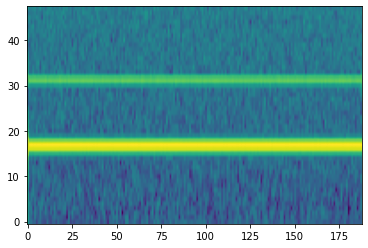

In [118]:
plt.imshow(train_set[0], aspect = 'auto', origin='below')

#2. Make a Deep Neural Network Model
- input : Spectrogram

- output : probabilites of classes

In [119]:
class PitchClassifier(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.layer = nn.Linear(in_features, out_features)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    out = self.layer(x)
    return out

pitch_classifier = PitchClassifier(48, 12)

train_set = train_set[:, :, 5]
test_set = test_set[:, :, 5]
pitch_classifier(train_set) 

tensor([[-5.0300,  5.7733, -8.1894,  ..., -4.2028,  3.5889, -4.3333],
        [-4.6428, -6.7635, -6.7841,  ..., 10.5618, -7.3468, -4.3046],
        [ 3.4712, 11.0429, -7.8592,  ..., -1.3063, 12.4321, -4.4698],
        ...,
        [ 1.8825, -7.4087, -4.5791,  ...,  4.0318, -7.4914, -0.5271],
        [ 3.6956, -2.0511, -9.7433,  ..., -4.0171,  5.8052, -3.1585],
        [ 7.6355, -3.1546, -8.6169,  ..., -2.7359,  4.4823, -5.0926]],
       grad_fn=<AddmmBackward>)

In [120]:
pitch_classifier(train_set).shape

torch.Size([960, 12])

In [121]:
import torch.nn.functional as F
test_output = pitch_classifier(train_set[:10])
output = F.softmax(test_output, dim = -1)
output

tensor([[9.4844e-06, 4.6644e-01, 4.0261e-07, 1.2257e-03, 4.2477e-05, 2.8977e-01,
         7.4491e-04, 1.8923e-01, 1.2004e-06, 2.1690e-05, 5.2496e-02, 1.9036e-05],
        [2.4864e-07, 2.9823e-08, 2.9215e-08, 3.1090e-05, 3.5070e-06, 7.4664e-08,
         1.8700e-03, 1.6552e-06, 7.6091e-04, 9.9733e-01, 1.6643e-08, 3.4870e-07],
        [9.8344e-05, 1.9103e-01, 1.1803e-09, 1.1014e-08, 1.1472e-05, 1.3894e-02,
         1.0949e-05, 2.8651e-02, 3.7247e-11, 8.2772e-07, 7.6630e-01, 3.4995e-08],
        [5.0361e-04, 3.4091e-32, 1.4265e-15, 8.0874e-27, 2.9761e-15, 2.2745e-10,
         2.0751e-38, 4.8312e-34, 1.1415e-04, 9.9938e-01, 6.9802e-11, 8.7896e-22],
        [7.7682e-01, 4.6860e-07, 6.1221e-07, 2.0617e-08, 8.9562e-08, 7.6198e-03,
         2.8448e-05, 2.5247e-05, 2.1540e-01, 5.9987e-06, 9.3460e-05, 9.9700e-06],
        [1.2409e-06, 3.6466e-07, 4.7234e-08, 1.1707e-04, 1.1229e-07, 8.3008e-06,
         9.7812e-01, 2.1692e-02, 4.4837e-05, 1.5045e-07, 1.5234e-09, 1.3706e-05],
        [4.7137e-01, 3

In [122]:
#scratch softmax function
def softmax(x, dim):
  exp_v = torch.exp(x)
  sum_v = torch.sum(exp_v, dim = dim, keepdim = True)
  return exp_v / sum_v


## 2.3 Loss function

In [128]:
def get_nll_loss(pred, target):
  #pred : softmax output
  #target : real label
  pred_for_target_class = pred[torch.arange(len(pred)), target]
  return torch.mean(-torch.log(pred_for_target_class))

loss = get_nll_loss(softmax(test_output, -1), train_label[:10])
print(loss)

tensor(18.0867, grad_fn=<MeanBackward0>)


In [129]:
pitch_classifier.layer.weight.grad

In [130]:
loss.backward()

##2.4 Optimizer

In [131]:
optimizer = torch.optim.Adam(pitch_classifier.parameters(), lr=0.001)

In [132]:
pitch_classifier.layer.weight[0]

tensor([-0.1162,  0.0313,  0.0713, -0.1013, -0.0544, -0.0244,  0.0504,  0.0796,
        -0.1349, -0.0214,  0.0071,  0.0672, -0.0209,  0.1036, -0.0141,  0.1386,
        -0.1137,  0.0393, -0.0189,  0.0526,  0.0611, -0.1339,  0.0080, -0.0567,
        -0.1155, -0.1246, -0.1249, -0.0679,  0.0119,  0.1326, -0.0658, -0.1073,
        -0.0152, -0.1150,  0.1216, -0.1099, -0.1092, -0.1114, -0.1303,  0.1158,
         0.0584,  0.1112, -0.0893, -0.0958, -0.0034, -0.1328,  0.1427, -0.1115],
       grad_fn=<SelectBackward>)

In [133]:
optimizer.step()

In [134]:
pitch_classifier.layer.weight[0]

tensor([-0.1152,  0.0323,  0.0723, -0.1003, -0.0534, -0.0234,  0.0494,  0.0786,
        -0.1359, -0.0224,  0.0081,  0.0662, -0.0219,  0.1026, -0.0151,  0.1396,
        -0.1127,  0.0403, -0.0199,  0.0516,  0.0601, -0.1329,  0.0090, -0.0557,
        -0.1145, -0.1236, -0.1239, -0.0669,  0.0129,  0.1336, -0.0648, -0.1063,
        -0.0142, -0.1140,  0.1226, -0.1089, -0.1082, -0.1104, -0.1293,  0.1168,
         0.0594,  0.1122, -0.0883, -0.0948, -0.0024, -0.1318,  0.1437, -0.1105],
       grad_fn=<SelectBackward>)

## 2.5 Make iteration loop

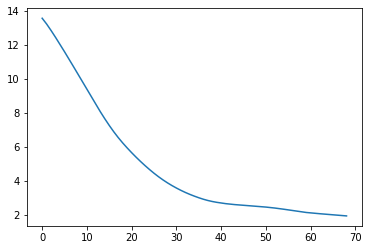

In [135]:
loss_tracker  = []

for i in range(300):
  
  pred = pitch_classifier(train_set)
  pred = softmax(pred, dim=-1)
  loss = get_nll_loss(pred, train_label)
  loss.backward()
  optimizer.step()
  loss_tracker.append(loss.item())

plt.plot(loss_tracker)